In [ ]:
import numpy as np
import os
import cv2
import csv
import matplotlib.pyplot as plt
import math
import sys
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
np.random.seed(1234)
tf.set_random_seed(1234)

In [ ]:
def initial_learning_rate(epoch):
    if (epoch >= 0) and (epoch < 300):
        return 0.01
    if (epoch >= 300) and (epoch < 800):
        return 0.001
    if (epoch >= 800) and (epoch < 1500):
        return 0.001
    else:
        return 0.0001

In [ ]:
class PDENet:
    # Init
    def __init__(self, xb, yb, tb, ub, vb, xi, yi, ti, ui, vi, x, y, t, layers):
        
        self.dim = 3
        
        self.xb = xb
        self.yb = yb
        self.tb = tb
        self.ub = ub
        self.vb = vb
        
        self.xi = xi
        self.yi = yi
        self.ti = ti
        self.ui = ui
        self.vi = vi

        self.x = x
        self.y = y
        self.t = t
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.init_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.xytb_tf = tf.placeholder(tf.float32, shape=[None, 3, 1])
        self.ub_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.vb_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.xyti_tf = tf.placeholder(tf.float32, shape=[None, 3, 1])
        self.ui_tf = tf.placeholder(tf.float32, shape=[None, 1])
        self.vi_tf = tf.placeholder(tf.float32, shape=[None, 1])

        self.xyt_tf = tf.placeholder(tf.float32, shape=[None, 3, 1])
        
        self.ub_pred, self.vb_pred, self.pb_pred, _ , _ , _ , _ , _ , _ , _ , _  = self.net_uv(self.xytb_tf)
        self.ui_pred, self.vi_pred, self.pi_pred, _ , _ , _ , _ , _ , _ , _ , _ = self.net_uv(self.xyti_tf)
        _ , _ , _ , self.f_u_pred, self.f_v_pred, self.div_u_pred = self.net_f_uv(self.xyt_tf)
        
        self.loss = tf.reduce_mean(tf.square(self.ub_pred - self.ub_tf) + tf.square(self.vb_pred - self.vb_tf)) + \
                    tf.reduce_mean(tf.square(self.ui_pred - self.ui_tf) + tf.square(self.vi_pred - self.vi_tf)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred) + tf.square(self.f_v_pred) + tf.square(self.div_u_pred))
                                   
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 10000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        # self.opt = tf.contrib.opt.ScipyOptimizerInterface(self.loss,method='SLSQP', options={'maxiter': 1000}) 
        self.lossHistogram = []
        # self.adaptive_rate = tf.placeholder(tf.float32)
        self.optimizer_Adam = tf.train.AdamOptimizer(learning_rate= 0.001, epsilon=0.0001)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def init_NN(self, layers):
        dim = self.dim
        weights = []
        biases = []
        num_layers = len(layers)
        W = self.xavier_init(size=[layers[0], dim])
        b = tf.Variable(tf.zeros([layers[0],1], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)  
        biases.append(b)
        for l in range(1,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l]])
            b = tf.Variable(tf.zeros([layers[l],1], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)  
        W = self.xavier_init(size=[3, layers[-1]])
        b = tf.Variable(tf.zeros([3,1], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)  
        biases.append(b) 
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def net_nn(self, X, weights, biases):
        num_layers = len(self.layers)
        H = X
        for l in range(0,num_layers-1):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(W, H), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(W, H), b)
        return Y

    def net_uv(self, xyt):
        uvp = self.net_nn(xyt, self.weights, self.biases)
        # psi = psi_p[:,0]
        # p = psi_p[:, 1]

        # u = tf.gradients(psi, y)[0]
        # v = - tf.gradients(psi, x)[0]
        u = uvp[:,0]
        v = uvp[:,1]
        p = uvp[:,2]
        u_x = tf.gradients(u, xyt)[0][:,0]
        u_y = tf.gradients(u, xyt)[0][:,1]
        v_x = tf.gradients(v, xyt)[0][:,0]
        v_y = tf.gradients(v, xyt)[0][:,1]
        p_x = tf.gradients(p, xyt)[0][:,0]
        p_y = tf.gradients(p, xyt)[0][:,1]
        u_t = tf.gradients(u, xyt)[0][:,2]
        v_t = tf.gradients(v, xyt)[0][:,2]

        return u, v, p, u_x, u_y, v_x, v_y, p_x, p_y, u_t, v_t
        
    def net_f_uv(self, xyt):
        u, v, p, u_x, u_y, v_x, v_y, p_x, p_y, u_t, v_t = self.net_uv(xyt)

        u_xx = tf.gradients(u_x, xyt)[0][:,0]
        u_yy = tf.gradients(u_y, xyt)[0][:,1]

        v_xx = tf.gradients(v_x, xyt)[0][:,0]
        v_yy = tf.gradients(v_y, xyt)[0][:,1]

        f_u = u_t - 0.01*(u_xx + u_yy) + (u*u_x + v*u_y) + p_x
        f_v = v_t - 0.01*(v_xx + v_yy) + (u*v_x + v*v_y) + p_y
        div_u = u_x + v_y
        
        return u, v, p, f_u, f_v, div_u
    
    def callback(self, loss):
        print('Loss: %.3e' % (loss))
        self.lossHistogram.append(loss)

    # def getbatch(self, data, n_batch, batch_size=10):
    #     data_batch = data[batch_size*n_batch:batch_size*(n_batch+1)]
    #     return data_batch
      
    def train(self, nIter): 

        tf_dict = {self.xytb_tf: np.concatenate([self.xb, self.yb, self.tb], 1), self.ub_tf: self.ub, self.vb_tf: self.vb,
                   self.xyti_tf: np.concatenate([self.xi, self.yi, self.ti], 1), self.ui_tf: self.ui, self.vi_tf: self.vi,
                   self.xyt_tf: np.concatenate([self.x, self.y, self.t], 1)}

        start_time = time.time()
        for it in range(nIter):
            # loss_ite = 0.0
            # for n_batch in range(int(self.x.size/10)):
            #     tf_dict = {self.xb_tf: self.getbatch(self.xb, n_batch), self.yb_tf: self.getbatch(self.yb, n_batch),
            #                self.ub_tf: self.getbatch(self.ub, n_batch), self.vb_tf: self.getbatch(self.vb, n_batch),
            #             self.x_tf: self.getbatch(self.x, n_batch), self.y_tf: self.getbatch(self.y, n_batch)}
            #     self.sess.run(self.train_op_Adam, tf_dict)
            #     loss_value = self.sess.run(self.loss, tf_dict)
            #     loss_ite = loss_ite + loss_value
            
            self.sess.run(self.train_op_Adam, tf_dict)
            elapsed = time.time() - start_time
            loss_value = self.sess.run(self.loss, tf_dict)
            print('It: %d, Loss: %.3e, Time: %.2f' % 
                    (it, loss_value, elapsed))
            self.lossHistogram.append(loss_value)
            start_time = time.time()
            
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
        # self.opt.minimize(self.sess,
        #                         feed_dict = tf_dict,
        #                         fetches = [self.loss],
        #                         loss_callback = self.callback)
            
    
    def predict(self, x, y, t):
        
        tf_dict = {self.xytb_tf: np.concatenate([x, y, t], 1)}
        
        u = self.sess.run(self.ub_pred, tf_dict)
        v = self.sess.run(self.vb_pred, tf_dict)
        p = self.sess.run(self.pb_pred, tf_dict)

        # tf_dict = {self.x_tf: x, self.y_tf: y}
        
        # f_u = self.sess.run(self.f_u_pred, tf_dict)
        # f_v = self.sess.run(self.f_v_pred, tf_dict)

        return u, v, p

In [ ]:
class sampling_from_rectangle:
	def __init__(self, x_range, y_range):
		self.x_range = x_range
		self.y_range = y_range

	def interior_samples(self, batchsize):
		int_draw_x = np.random.uniform(self.x_range[0], self.x_range[1], batchsize)
		int_draw_y = np.random.uniform(self.y_range[0], self.y_range[1], batchsize)

		return int_draw_x, int_draw_y

	def boundary_samples(self, batchsize):
		a = self.x_range[1]-self.x_range[0]
		b = self.y_range[1]-self.y_range[0]

		draw_perimeter = np.random.uniform(0, 2*(a + b), batchsize)

		draw = []

		for i in draw_perimeter:
			if i < a:
				draw.append([i+ self.x_range[0], self.y_range[0]])
			elif a <= i and i < a+b:
				draw.append([self.x_range[1], (i-a) + self.y_range[0]])
			elif a+b <= i and i < 2*a+b:
				draw.append([self.x_range[1] - (i-(a+b)), self.y_range[1]])
			elif 2*a+b <= i and i<= 2*a+2*b:
				draw.append([self.x_range[0], self.y_range[1] - (i-(2*a+b))])

		return np.array(draw)[:, 0], np.array(draw)[:, 1]

In [ ]:
sampler = sampling_from_rectangle([-0.5, 0.5], [-0.5, 0.5])
N = 2500;
filename = 'data_'

nu = 0.025
lambda_1 = 1.0/(2.0*nu) - np.sqrt(1.0/(4.0*nu*nu)+4.0*np.pi*np.pi)
with open(filename + str(N) + '.csv', mode='w') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    bou_draw_x, bou_draw_y = sampler.boundary_samples(N)
    int_draw_x, int_draw_y = sampler.interior_samples(N)
    
    for i in range(N):
        csv_writer.writerow([int_draw_x[i], int_draw_y[i], bou_draw_x[i], bou_draw_y[i], 1.0-np.exp(lambda_1*bou_draw_x[i])*np.cos(2.0*np.pi*bou_draw_y[i]), lambda_1/(2.0*np.pi)*np.exp(lambda_1*bou_draw_x[i])*np.sin(2.0*np.pi*bou_draw_y[i])])

dataset = np.genfromtxt('data_2500.csv', delimiter=',')
print(dataset)

[[ 6.28699753e-02 -4.60827396e-01 -4.34790114e-01  5.00000000e-01
   2.52047816e+00 -2.85608612e-17]
 [ 3.92092725e-02  6.37351115e-03 -5.00000000e-01 -4.87179416e-01
   2.61384943e+00  1.99835091e-02]
 [-4.00567943e-01  2.27736396e-01 -5.00000000e-01 -4.22301193e-01
   2.42995719e+00  1.16481681e-01]
 ...
 [ 2.75810131e-01  2.08471284e-01  2.30585687e-01  5.00000000e-01
   1.80073536e+00 -1.50411180e-17]
 [-6.05847931e-02  2.96578843e-01  1.15243291e-01 -5.00000000e-01
   1.89488091e+00  1.68095604e-17]
 [ 8.39548529e-02  1.54341952e-01 -3.79643849e-01 -5.00000000e-01
   2.44177958e+00  2.70825768e-17]]


In [ ]:
def flatArr(x):
    y = []
    for row in x:
        for el in row:
            y.append(el)
    return np.array(y).flatten()

def splitData(data):
    x = []
    y = []
    xb = []
    yb = []
    ub = []
    vb = []
    u = []
    v = []
    for row in data:
        if (row[0] == 0. or row[1] == 0. or row[0] == 1.):
            xb.append(row[0])
            yb.append(row[1])
            ub.append(0.0)
            vb.append(0.0)
        elif (row[1] == 1.):
            xb.append(row[0])
            yb.append(row[1])
            ub.append(1.0)
            vb.append(0.0)
        else:
            x.append(row[0])
            y.append(row[1])
            u.append(0.0)
            v.append(0.0)
    return np.array(x), np.array(y), np.array(u), np.array(v), np.array(xb), np.array(yb), np.array(ub), np.array(vb)

def sample(T, delta_t, data):
    xi,yi,ui,vi,xb,yb,ub,vb = splitData(data)
    x_arr = np.array([])
    y_arr = np.array([])
    NT = np.int(T/delta_t)
    t = []
    for i in range(NT):
        t.append([round((i+1)*delta_t,6) for e in range(xi.size)])
        x_arr = np.concatenate((x_arr, xi))
        y_arr = np.concatenate((y_arr, yi))
    t = flatArr(t)
    tb = []
    xb_arr = np.array([])
    yb_arr = np.array([])
    ub_arr = np.array([])
    for i in range(NT+1):
        tb.append([round(i*delta_t,6) for e in range(xb.size)])
        xb_arr = np.concatenate((xb_arr, xb))
        yb_arr = np.concatenate((yb_arr, yb))
        ub_arr = np.concatenate((ub_arr, ub))
    tb = flatArr(tb)
    ti = np.array([0.0 for e in range(xi.size)])
    vb = np.array([0.0 for e in xb_arr])

    return x_arr, y_arr, t, xi, yi, ti, ui, vi, xb_arr, yb_arr, tb, ub_arr, vb

In [ ]:
dataset = np.genfromtxt('triangle_data_30_30.txt', delimiter=',')
x, y, t, xi, yi, ti, ui, vi, xb, yb, tb, ub, vb = sample(4.0, 0.5, dataset)
x = x.reshape((x.size, 1, 1))
y = y.reshape((y.size, 1, 1))
t = t.reshape((t.size, 1, 1))
xb = xb.reshape((xb.size, 1, 1))
yb = yb.reshape((yb.size, 1, 1))
tb = tb.reshape((tb.size, 1, 1))
ub = ub.reshape((ub.size, 1))
vb = vb.reshape((vb.size, 1))
xi = xi.reshape((xi.size, 1, 1))
yi = yi.reshape((yi.size, 1, 1))
ti = ti.reshape((ti.size, 1, 1))
ui = ui.reshape((ui.size, 1))
vi = vi.reshape((vi.size, 1))
layers = [32, 32, 32, 32, 32, 32]


In [ ]:
t.size

8016

In [ ]:
xb.size

1080

In [ ]:
xi.size

1002

Streaming output truncated to the last 5000 lines.
Loss: 1.129e-04
Loss: 1.129e-04
Loss: 1.129e-04
Loss: 1.128e-04
Loss: 1.128e-04
Loss: 1.128e-04
Loss: 1.127e-04
Loss: 1.126e-04
Loss: 1.126e-04
Loss: 1.125e-04
Loss: 1.125e-04
Loss: 1.125e-04
Loss: 1.124e-04
Loss: 1.123e-04
Loss: 1.122e-04
Loss: 1.122e-04
Loss: 1.121e-04
Loss: 1.121e-04
Loss: 1.120e-04
Loss: 1.119e-04
Loss: 1.124e-04
Loss: 1.119e-04
Loss: 1.119e-04
Loss: 1.118e-04
Loss: 1.118e-04
Loss: 1.117e-04
Loss: 1.116e-04
Loss: 1.115e-04
Loss: 1.114e-04
Loss: 1.114e-04
Loss: 1.113e-04
Loss: 1.113e-04
Loss: 1.113e-04
Loss: 1.113e-04
Loss: 1.112e-04
Loss: 1.111e-04
Loss: 1.111e-04
Loss: 1.111e-04
Loss: 1.110e-04
Loss: 1.109e-04
Loss: 1.109e-04
Loss: 1.108e-04
Loss: 1.108e-04
Loss: 1.107e-04
Loss: 1.106e-04
Loss: 1.106e-04
Loss: 1.105e-04
Loss: 1.105e-04
Loss: 1.105e-04
Loss: 1.104e-04
Loss: 1.103e-04
Loss: 1.103e-04
Loss: 1.102e-04
Loss: 1.102e-04
Loss: 1.101e-04
Loss: 1.101e-04
Loss: 1.101e-04
Loss: 1.100e-04
Loss: 1.100e-04
Loss:

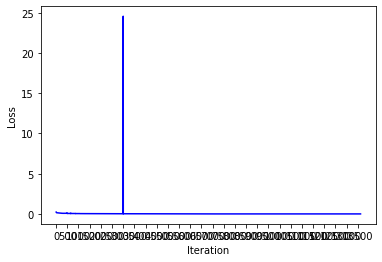

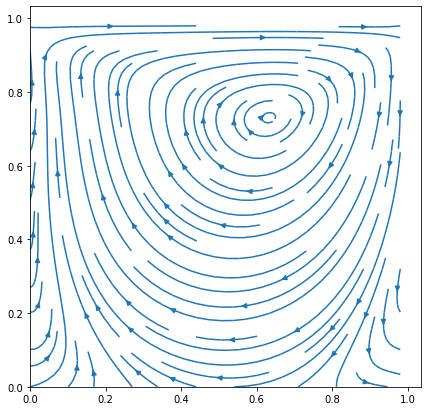

In [ ]:
model = PDENet(xb, yb, tb, ub, vb, xi, yi, ti, ui, vi, x, y, t, layers)
start_time = time.time()                
model.train(3000)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))
losses = np.array(model.lossHistogram)
losses = losses.reshape(len(losses))
epochs = losses.size
x_epochs = [i + 1 for i in range(epochs)]
plt.xticks(np.arange(0, epochs+1 , 500))

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.plot(x_epochs, losses, color = 'blue')
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
T = np.array([4.0 for e in X])
T = T.reshape((T.size, 1, 1))
U, V, _  = model.predict(X1, Y1, T)
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 50))
V = np.reshape(V, (-1, 50))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 

In [ ]:
len(model.lossHistogram)


10395

In [ ]:
def splitDataTest(data):
    x = []
    y = []
    u = []
    v = []
    t = []
    for row in data:
            x.append(row[0])
            y.append(row[1])
            u.append(row[2])
            v.append(row[3])
            t.append(4.0)
    return np.array(x), np.array(y), np.array(t), np.array(u), np.array(v)

In [ ]:
datasetTest = np.genfromtxt('xyuv_30_30.txt', delimiter=',')
x, y, t, u, v = splitDataTest(datasetTest)
x = x.reshape((x.size, 1, 1))
y = y.reshape((y.size, 1, 1))
t = t.reshape((t.size, 1, 1))
u = u.reshape((u.size, 1))
v = v.reshape((v.size, 1))
u_pred, v_pred, _ = model.predict(x, y, t)

In [ ]:
x.size

961

In [ ]:
u_pred[800:810]

array([[0.00022206],
       [0.00022098],
       [0.00021979],
       [0.00021821],
       [0.00021675],
       [0.0002152 ],
       [0.00022912],
       [0.00022772],
       [0.00022629],
       [0.00022483]], dtype=float32)

In [ ]:
u[800:810]

array([[ 3.10682e-02],
       [-2.50163e-02],
       [-6.66477e-02],
       [-6.94820e-02],
       [-3.03186e-02],
       [ 1.39980e-33],
       [ 7.23732e-34],
       [-2.49900e-02],
       [-6.17707e-02],
       [-8.02430e-02]])

In [ ]:
with tf.Session() as sess:
    result = u_e.eval()

    print(result) 

    print(type(result))

In [ ]:
u_pred

In [ ]:
sampler = sampling_from_rectangle([-0.5, 0.5], [-0.5, 0.5])
N = 200;
filename = 'data_'

nu = 0.025
lambda_1 = 1.0/(2.0*nu) - np.sqrt(1.0/(4.0*nu*nu)+4.0*np.pi*np.pi)
with open(filename + str(N) + '.csv', mode='w') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    bou_draw_x, bou_draw_y = sampler.boundary_samples(N)
    int_draw_x, int_draw_y = sampler.interior_samples(N)
    
    for i in range(N):
        csv_writer.writerow([int_draw_x[i], int_draw_y[i], bou_draw_x[i], bou_draw_y[i], 1.0-np.exp(lambda_1*bou_draw_x[i])*np.cos(2.0*np.pi*bou_draw_y[i]), lambda_1/(2.0*np.pi)*np.exp(lambda_1*bou_draw_x[i])*np.sin(2.0*np.pi*bou_draw_y[i])])

dataset = np.genfromtxt('data_200.csv', delimiter=',')
print(dataset)

In [ ]:
dataset = np.genfromtxt('data_500.csv', delimiter=',')
# x, y, xb, yb, ub, vb = splitData(dataset)
x = dataset[:,0]
x = x.reshape((x.size, 1, 1))
y = dataset[:,1]
y = y.reshape((y.size, 1, 1))
xb = dataset[:,2]
xb = xb.reshape((xb.size, 1, 1))
yb = dataset[:,3]
yb = yb.reshape((yb.size, 1, 1))
ub = dataset[:,4]
ub = ub.reshape((ub.size, 1))
vb = dataset[:,5]
vb = vb.reshape((ub.size, 1))

In [ ]:
u_pred, v_pred, _ = model.predict(x, y)
u_e, v_e = exact_solution(x, y)

In [ ]:
u_e = tf.reshape(u_e, [x.size, 1])
v_e = tf.reshape(v_e, [x.size, 1])
LossL2 = tf.reduce_mean(tf.square(u_pred - u_e)) + tf.reduce_mean(tf.square(v_pred - v_e))
with tf.Session() as sess:
    result = LossL2.eval()

    print(result) 

    print(type(result))

0.00013639778107128715
<class 'numpy.float64'>


In [ ]:
LossL2 = tf.math.sqrt(LossL2)
with tf.Session() as sess:
    result = LossL2.eval()

    print(result) 

    print(type(result))

0.011678946059952806
<class 'numpy.float64'>


In [ ]:
ub_e = tf.reshape(ub_e, [xb.size, 1])
vb_e = tf.reshape(vb_e, [xb.size, 1])
LossL2 = tf.reduce_mean(tf.square(ub_pred - ub_e)) + tf.reduce_mean(tf.square(vb_pred - vb_e))
with tf.Session() as sess:
    result = LossL2.eval()

    print(result) 

    print(type(result))

0.16788045315411565
<class 'numpy.float64'>


In [ ]:
LossL2 = tf.math.sqrt(LossL2)
with tf.Session() as sess:
    result = LossL2.eval()

    print(result) 

    print(type(result))

0.2556425507026192
<class 'numpy.float64'>


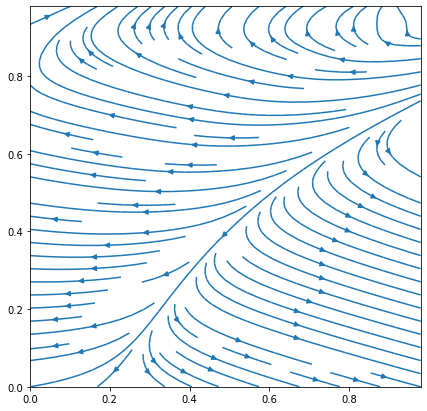

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
T = np.array([4.0 for e in X])
T = T.reshape((T.size, 1, 1))
U, V, _  = model.predict(X1, Y1, T)
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 50))
V = np.reshape(V, (-1, 50))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 

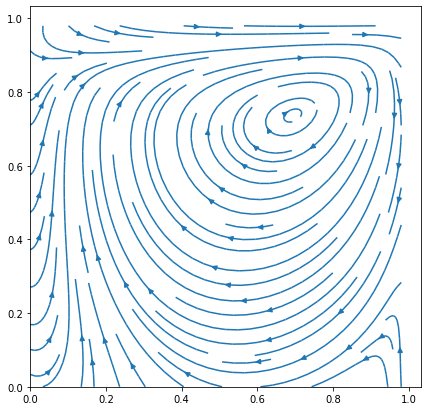

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
T = np.array([4.0 for e in X])
T = T.reshape((T.size, 1, 1))
U, V, _  = model.predict(X1, Y1, T)
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 50))
V = np.reshape(V, (-1, 50))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 

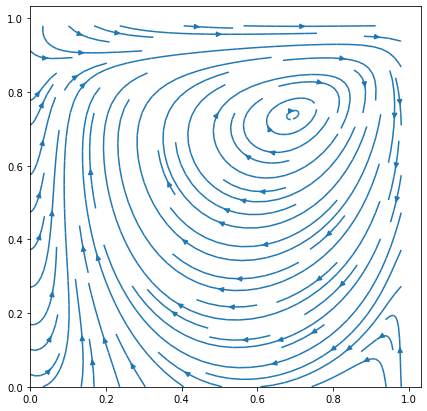

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
T = np.array([3.0 for e in X])
T = T.reshape((T.size, 1, 1))
U, V, _  = model.predict(X1, Y1, T)
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 50))
V = np.reshape(V, (-1, 50))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 

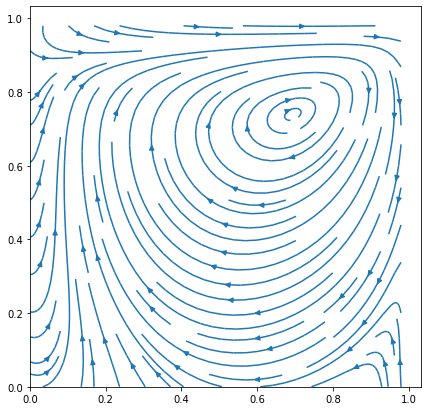

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
T = np.array([2.0 for e in X])
T = T.reshape((T.size, 1, 1))
U, V, _  = model.predict(X1, Y1, T)
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 50))
V = np.reshape(V, (-1, 50))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 

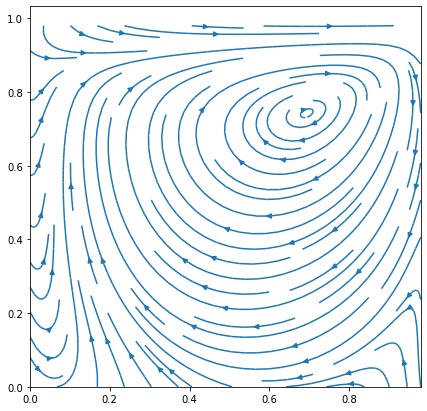

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
T = np.array([0.5 for e in X])
T = T.reshape((T.size, 1, 1))
U, V, _  = model.predict(X1, Y1, T)
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 50))
V = np.reshape(V, (-1, 50))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 

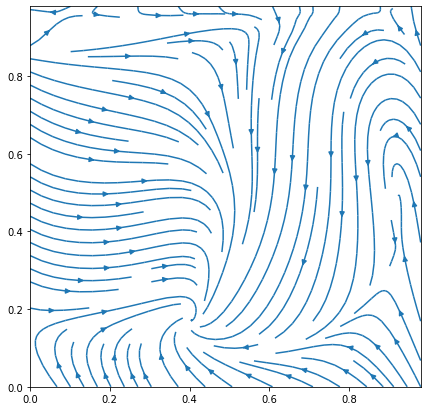

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
T = np.array([0.0 for e in X])
T = T.reshape((T.size, 1, 1))
U, V, _  = model.predict(X1, Y1, T)
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 50))
V = np.reshape(V, (-1, 50))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 

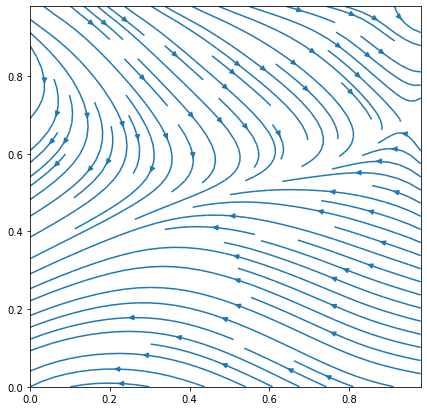

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
T = np.array([0.0 for e in X])
T = T.reshape((T.size, 1, 1))
U, V, _  = model.predict(X1, Y1, T)
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 50))
V = np.reshape(V, (-1, 50))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 

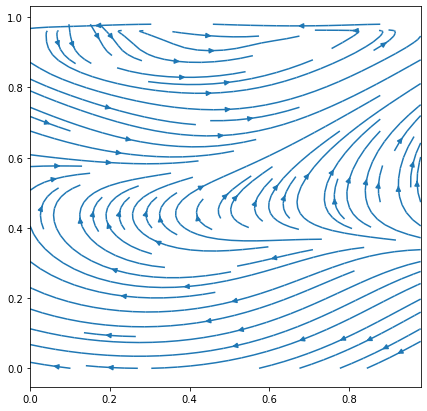

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
T = np.array([0.5 for e in X])
T = T.reshape((T.size, 1, 1))
U, V, _  = model.predict(X1, Y1, T)
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 50))
V = np.reshape(V, (-1, 50))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 

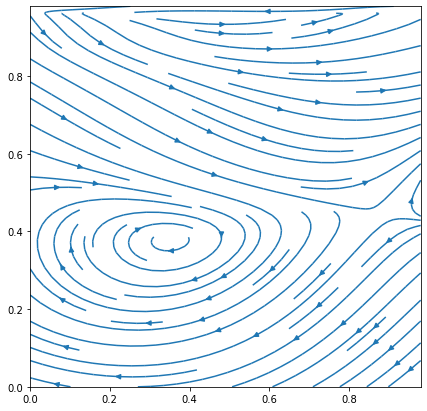

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
T = np.array([2.0 for e in X])
T = T.reshape((T.size, 1, 1))
U, V, _  = model.predict(X1, Y1, T)
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 50))
V = np.reshape(V, (-1, 50))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 

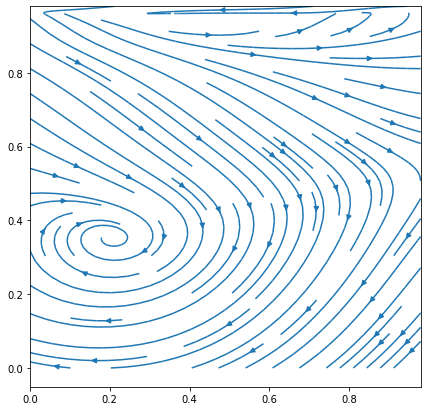

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
T = np.array([3.8 for e in X])
T = T.reshape((T.size, 1, 1))
U, V, _  = model.predict(X1, Y1, T)
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 50))
V = np.reshape(V, (-1, 50))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 

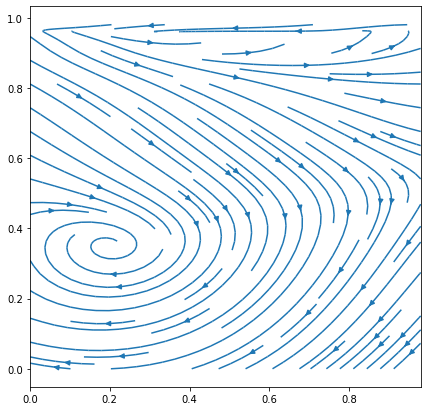

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
T = np.array([3.9 for e in X])
T = T.reshape((T.size, 1, 1))
U, V, _  = model.predict(X1, Y1, T)
Y, X = np.mgrid[0:1:0.02, 0:1:0.02] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 50))
V = np.reshape(V, (-1, 50))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 

In [ ]:
Y, X = np.mgrid[0:1:0.01, 0:1:0.01] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
T = np.array([2.5 for e in X])
T = T.reshape((T.size, 1, 1))

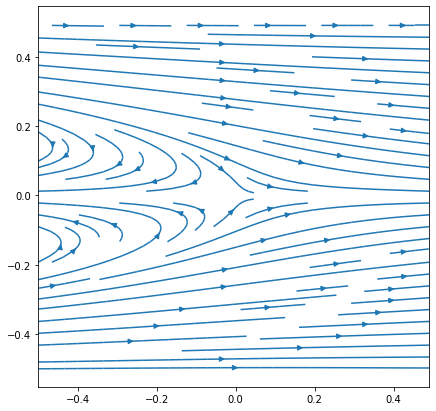

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[-0.5:0.5:0.01, -0.5:0.5:0.01] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
U, V, _  = model.predict(X1, Y1)
Y, X = np.mgrid[-0.5:0.5:0.01, -0.5:0.5:0.01] 
U = U.flatten()
V = V.flatten()
U = np.reshape(U, (-1, 100))
V = np.reshape(V, (-1, 100))
fig = plt.figure(figsize = (7, 7)) 

plt.streamplot(X, Y, U, V, density = 1) 
  
# show plot 
plt.show() 

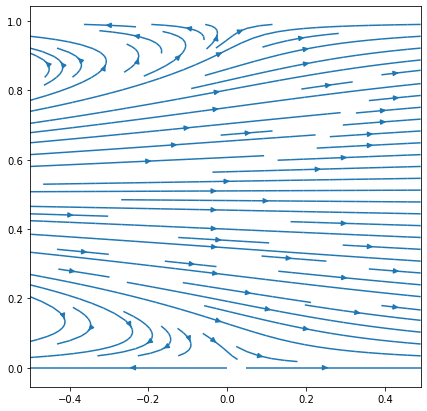

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[0:1:0.01, -0.5:0.5:0.01] 
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
U, V = exact_solution(X1, Y1)
Y, X = np.mgrid[0:1:0.01, -0.5:0.5:0.01] 
# U = U.flatten()
# V = V.flatten()
# U = np.reshape(U, (-1, 100))
# V = np.reshape(V, (-1, 100))
fig = plt.figure(figsize = (7, 7)) 
with tf.Session() as sess:
    U = np.reshape(U.eval().flatten(), (-1, 100))
    V = np.reshape(V.eval().flatten(), (-1, 100))
    plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 

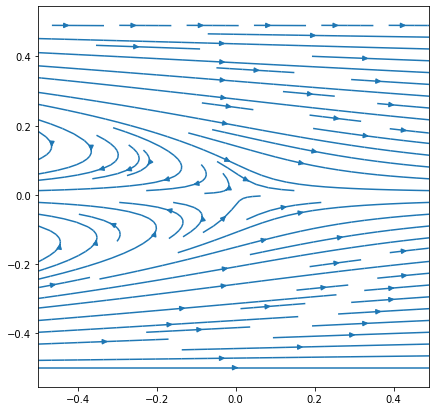

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
Y, X = np.mgrid[-0.5:0.5:0.01, -0.5:0.5:0.01]  
Y = Y.flatten()
X = X.flatten()
Y1 = Y.reshape((Y.size, 1, 1))
X1 = X.reshape((X.size, 1, 1))
U, V = exact_solution(X1, Y1)
Y, X = np.mgrid[-0.5:0.5:0.01, -0.5:0.5:0.01]  
# U = U.flatten()
# V = V.flatten()
# U = np.reshape(U, (-1, 100))
# V = np.reshape(V, (-1, 100))
fig = plt.figure(figsize = (7, 7)) 
with tf.Session() as sess:
    U = np.reshape(U.eval().flatten(), (-1, 100))
    V = np.reshape(V.eval().flatten(), (-1, 100))
    plt.streamplot(X, Y, U, V, density = 1) 

# show plot 
plt.show() 